# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        
        ### Kod kradziony przyznaję się bez bicia
    def save(self, scene_index, path='.'):
        plt.close()
        ax = plt.axes()
        plt.axis('square')
        scene = self.scenes[scene_index]
        for collection in scene.points:
            if len(collection.points) > 0:
                ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (scene.lines):
            ax.add_collection(collection.get_collection())
        ax.autoscale(True)
        plt.savefig(path+"/figure_"+str(scene_index)+".png")
        

# Rozwiązanie

In [3]:
%matplotlib notebook

##### Przydatne Funkcje

In [4]:
#funkcja przetwarza linie tak, że punkt o mniejszej współżędnej x jest na pierwszym miejscu w krotce
def line_repair(lines):
    for i in range(len(lines)):
        if lines[i][0][0] > lines[i][1][0]:
            lines[i] = (lines[i][1], lines[i][0])
        else:
            lines[i] = (lines[i][0], lines[i][1])
            

#fukncja porównująca linie (*)
def lines_compare(l1,l2):
    if l1[0][0] > l1[1][0]:
        l1[0][0], l1[1][0] = l1[1][0], l1[0][0]
    if l2[0][0] > l2[1][0]:
        l2[0][0], l2[1][0] = l2[1][0], l2[0][0]
        
    a1 = (l1[1][1] - l1[0][1])/(l1[1][0]-l1[0][0])
    a2 = (l2[1][1] - l2[0][1])/(l2[1][0]-l2[0][0])
    b1 = l1[0][1] - l1[0][0]*a1
    b2 = l2[0][1] - l2[0][0]*a2
    if l1[0][0] > l2[0][0]:
        x = l1[0][0]
    else:
        x = l2[0][0]
    
    if x*a1+b1 > x*a2+b2:
        return 1
    elif x*a1 + b1 < x*a2 + b2:
        return -1
    else: return 0

#funkcja znajdująca punkt przecięcia 2 linii
def intersect(l1,l2):
    if l1[0][0] > l2[0][0]:
        l1,l2 = l2,l1
    kx = l1[0][0] - l2[0][0]
    ky = l1[0][1] - l2[0][1]
    lx = l1[1][0] - l1[0][0]
    ly = l1[1][1] - l1[0][1]
    mx = l2[1][0] - l2[0][0]
    my = l2[1][1] - l2[0][1]
    if (lx*my - ly*mx) == 0:
        return None
    t = (ky*mx - kx*my)/(lx*my - ly*mx)
    r = (kx*ly-ky*lx)/(ly*mx - lx*my)
    if t <= 1 and t >= 0 and r <= 1 and r >= 0:
        return ((l1[0][0] + t*lx),(l1[0][1] + t*ly))
    else: return None

In [5]:
import functools
import sortedcontainers
import copy as cp

In [6]:
#fukncja znajdująca jeden punkt przecięcia
def one_intersection(lines):
    
    
    
    #naprawianie odcinków
    line_repair(lines)
    
    
    
    n = len(lines)
    
    
    
    #znajdowanie granic dla miotły
    """max_y,min_y = lines[0][0][1],lines[0][1][1]
    for i in range(n):
        if lines[i][0][1] > max_y:
            max_y = lines[i][0][1]
        if lines[i][1][1] > max_y:
            max_y = lines[i][1][1]
        if lines[i][0][1] < min_y:
            min_y = lines[i][0][1]
        if lines[i][1][1] < min_y:
            min_y = lines[i][1][1]"""
    
    
    
    #tabela określająca czy odcinek pojawił się już na miotle
    visited = [False]*n
    
    
    
    #struktura zdażeń w formie tabeli punktów uporządkowanych po współżędnej x
    #przechowujemy współżędną x po której sortujemy oraz indeks linii do której należy punkt
    points = [ [lines[i][0][0],i] for i in range(n) ] + [ [lines[i][1][0],i] for i in range(n) ]
    points = sorted(points, key = lambda p: p[0])


    
    #struktura stanu. SortedSet z kuczem w postaci funkcji porównującej linie (*)
    T = sortedcontainers.SortedSet( key = functools.cmp_to_key(lambda a, b: lines_compare(a,b)) )
   


    #przechodzimy przez tabelę
    for j in range(2*n):
        #podejmujemy punkt ze struktury zdażeń
        i = points[j][1]
        
        #broom = ((points[j][0],min_y),(points[j][0],max_y))
        
        #operacje jeśli jest to początek odcinka
        if not visited[i]:
            T.add(lines[i])
            
            #sprawdzamy punkt przecięcia nowego odcinka na miotle z jego sąsiadami
            #maybe to potencjalny punkt przecięcia który może być None
            ind = T.index(lines[i])
            if ind > 0:
                maybe = intersect(lines[i],T[ind-1])
                if maybe != None:
                    return maybe
            if ind < len(T)-1 :
                maybe = intersect(lines[i],T[ind+1])
                if maybe != None:
                    return maybe
            visited[i] = True
            
            
        #jeśli koniec odcinka
        else: 
            #sprawdzamy czy sąsiedzi odcinka się przecinają
            ind = T.index(lines[i])
            if ind < len(T)-1 and ind > 0:
                maybe = intersect(T[ind-1],T[ind+1])
                if maybe != None:
                    return maybe
            
            #usuwamy odcinek z miotły
            T.discard(lines[i])
            
    return None


In [7]:
#wersja graficzna
def one_intersection_animation(lines):
    line_repair(lines)
    n = len(lines)
    max_y,min_y = lines[0][0][1],lines[0][1][1]
    for i in range(n):
        if lines[i][0][1] > max_y:
            max_y = lines[i][0][1]
        if lines[i][1][1] > max_y:
            max_y = lines[i][1][1]
        if lines[i][0][1] < min_y:
            min_y = lines[i][0][1]
        if lines[i][1][1] < min_y:
            min_y = lines[i][1][1]
    
    
    visited = [False]*n
    points = [ [lines[i][0][0],i] for i in range(n) ] + [ [lines[i][1][0],i] for i in range(n) ]
    points = sorted(points, key = lambda p: p[0])
    
    scenes = [Scene(lines = [LinesCollection(lines)])]
    
    T = sortedcontainers.SortedSet( key = functools.cmp_to_key(lambda a, b: lines_compare(a,b)) )
    
    T_array = []
    for j in range(2*n):
        i = points[j][1]
        broom = ((points[j][0],min_y),(points[j][0],max_y))
        if not visited[i]:
            T.add(lines[i])
            T_array.append(lines[i])
            scenes.append(Scene(lines = [LinesCollection(lines),
                                         LinesCollection(cp.copy(T_array),color = 'green'),
                                         LinesCollection([broom],color = 'red')]))
            ind = T.index(lines[i])
            if ind > 0:
                maybe = intersect(lines[i],T[ind-1])
                if maybe != None:
                    #return maybe
                    scenes.append(Scene(lines = [LinesCollection(lines),
                                         LinesCollection(cp.copy(T_array),color = 'green'),
                                         LinesCollection([broom],color = 'red')],
                                       points = [PointsCollection([maybe],color = 'red')]))
                    return scenes
            if ind < len(T)-1 :
                maybe = intersect(lines[i],T[ind+1])
                if maybe != None:
                    #return maybe
                    scenes.append(Scene(lines = [LinesCollection(lines),
                                         LinesCollection(cp.copy(T_array),color = 'green'),
                                         LinesCollection([broom],color = 'red')],
                                       points = [PointsCollection([maybe],color = 'red')]))
                    return scenes
            visited[i] = True
        else: 
            ind = T.index(lines[i])
            if ind < len(T)-1 and ind > 0:
                maybe = intersect(T[ind-1],T[ind+1])
                if maybe != None:
                    #return maybe
                    return scenes
            T.discard(lines[i])
            T_array.remove(lines[i])
            scenes.append(Scene(lines = [LinesCollection(lines),
                                         LinesCollection(cp.copy(T_array),color = 'green'),
                                         LinesCollection([broom],color = 'red')]))
    
    #return None
    return scenes

##### Interaktywne zadawanie odcinków

<IPython.core.display.Javascript object>


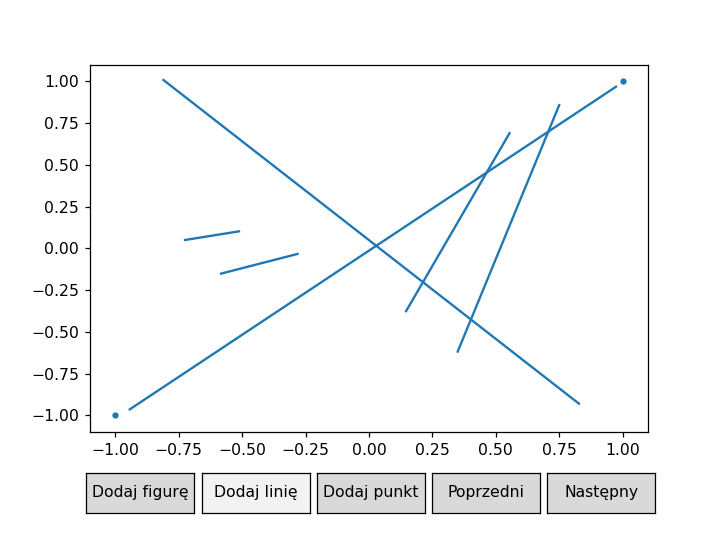

In [8]:
#Dodaj tu punkty, figury i/lub odcinki!
plot11 = Plot(points = [PointsCollection([(-1,-1),(1,1)], marker = ".")])
plot11.draw()

<IPython.core.display.Javascript object>


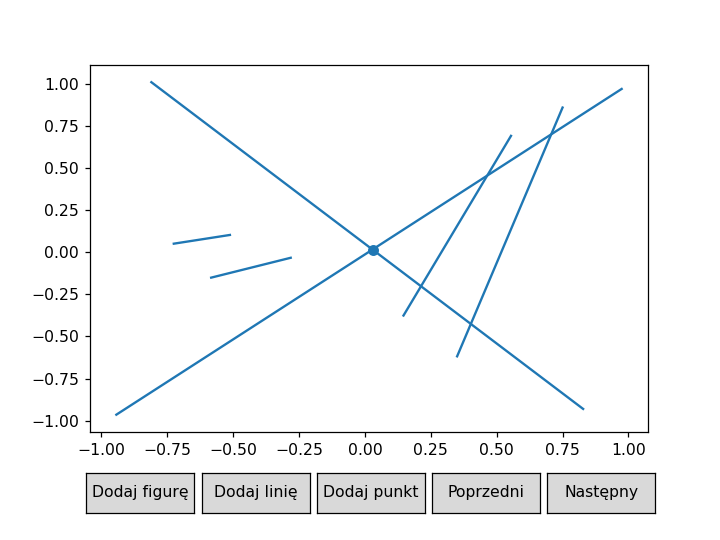

In [9]:
lines1 = plot11.get_added_lines()[0].lines
p = one_intersection(lines1)
if p != None:
    plot12 = Plot( lines = [LinesCollection(lines1)], points = [PointsCollection([p])] )
    plot12.draw()
else:
    print("there's no intersection")

<IPython.core.display.Javascript object>


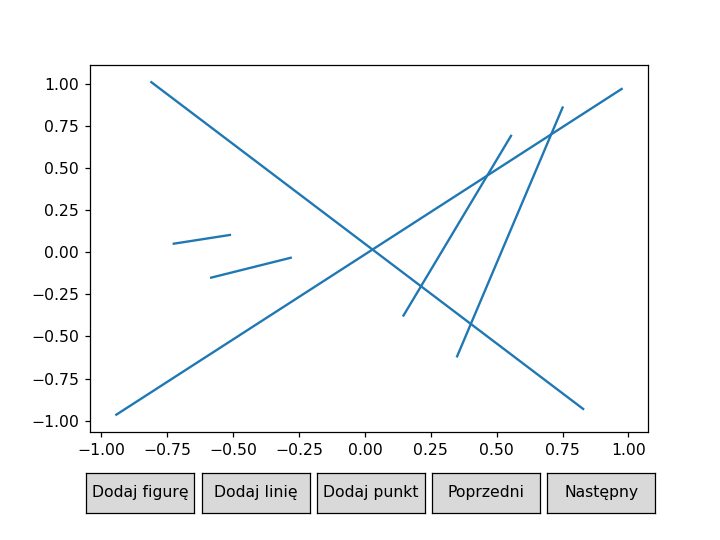

In [22]:
scenes1 = one_intersection_animation(lines1)
plot13 = Plot(scenes = scenes1)
#plot12 = Plot( lines = [LinesCollection(lines)], points = [PointsCollection([one_intersection(lines)])] )
plot13.draw()

In [11]:
#generowanie n odcinków o współżędnych z zadanego zakresu
def generate(n=10,down=-10,up=10,left=-10,right=10):
    lines = []
    for i in range(n):
        x1,y1= np.random.uniform(left,right), np.random.uniform(down,up)
        x2,y2 = x1,y1
        while x2 == x1:
            x1 = np.random.uniform(left,right)
        while y2 == y1:
            y2 = np.random.uniform(down,up)
        lines.append(((x1,y1),(x2,y2)))
    return lines

In [39]:
lines2 = generate()

<IPython.core.display.Javascript object>


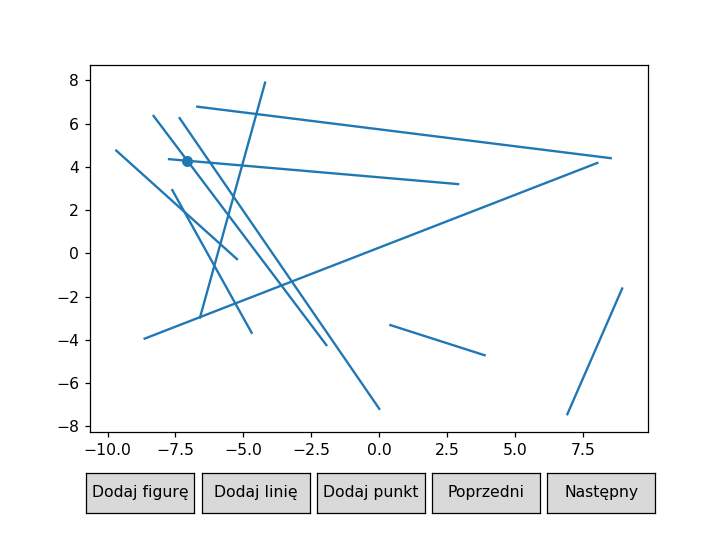

In [40]:
p2 = one_intersection(lines2)
if p != None:
    plot21 = Plot( lines = [LinesCollection(lines2)], points = [PointsCollection([p2])] )
    plot21.draw()
else:
    print("there's no intersection")

<IPython.core.display.Javascript object>


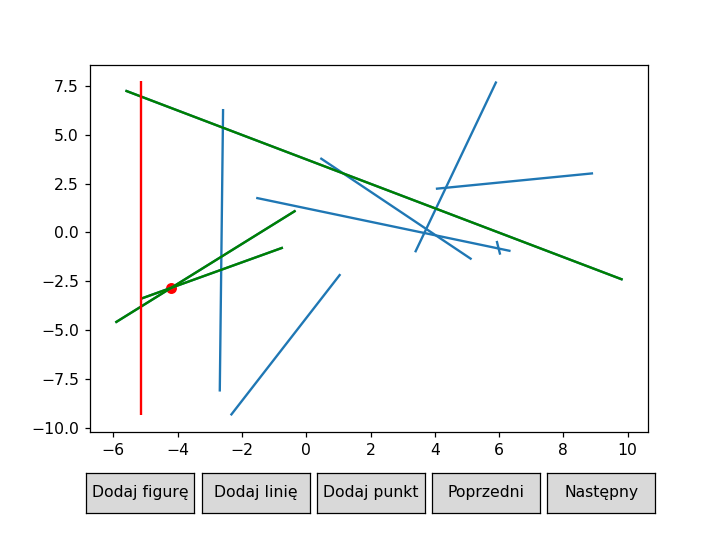

In [14]:
scenes2 = one_intersection_animation(lines2)
plot22 = Plot(scenes = scenes2)

plot22.draw()

#plot12 = Plot(lines = [LinesCollection(lines)],points = [PointsCollection([one_intersection(lines)])])
#plot12.draw()

##### Wszystkie punkty przecięcia

In [15]:
from queue import PriorityQueue

In [16]:
def intersections(lines):
    
    
    
    #naprawianie odcinków
    line_repair(lines)
    n = len(lines)
    
    
    
    #y minimalne i maksymalne oraz najmniejszy x
    max_y,min_y,min_x = lines[0][0][1],lines[0][1][1],lines[0][0][0]
    for i in range(n):
        if lines[i][0][1] > max_y:
            max_y = lines[i][0][1]
        if lines[i][1][1] > max_y:
            max_y = lines[i][1][1]
        if lines[i][0][1] < min_y:
            min_y = lines[i][0][1]
        if lines[i][1][1] < min_y:
            min_y = lines[i][1][1]
        if lines[i][0][0] < min_x:
            min_x = lines[i][0][0]
    
    
    
    
    #inicjalizacja pozycji miotły jako najmniejszy x
    x = min_x
    
    
    
    
    #nowa funkcja porównująca odcinki i biorąca pod uwagę aktualną pozycję miotły
    def lines_compare_2(a,b):
        l1,l2 = lines[a],lines[b]
        nonlocal x
        inter = intersect(l1,l2)
        if l1[0][0] > l1[1][0]:
            l1[0], l1[1] = l1[1], l1[0]
        if l2[0][0] > l2[1][0]:
            l2[0], l2[1] = l2[1], l2[0]
        a1 = (l1[1][1] - l1[0][1])/(l1[1][0]-l1[0][0])
        a2 = (l2[1][1] - l2[0][1])/(l2[1][0]-l2[0][0])
        b1 = l1[0][1] - l1[0][0]*a1
        b2 = l2[0][1] - l2[0][0]*a2
        if l1[0][0] > l2[0][0]:
            p = l1[0][0]
        else:
            p = l2[0][0]
        if inter == None or inter[0] > x:
            k = 1
        else: k = -1
            
        if p*a1+b1 > p*a2+b2:
            return k
        elif p*a1 + b1 < p*a2 + b2:
            return -k
        else: return 0
        
            
        
    #struktura stanu. SortedSet z kluczem w postaci nowej funkcji porównującej odcinki
    T = sortedcontainers.SortedSet( key = functools.cmp_to_key(lambda a, b: lines_compare_2(a,b)) )
    #do interpretacji graficznej
    T_array = [] 
    scenes = [Scene(lines = [LinesCollection(lines)])]
    
    
    
    #tablica mówiąca czy odcinki były już na miotle
    visited = [False]*n
    
    
    
    #struktura zdażeń - kolejka priorytetowa
    Q = PriorityQueue()
    for i in range(n):
        Q.put((lines[i][0][0],(i,i)))
        Q.put((lines[i][1][0],(i,i)))
        

    #zbiór zapobiegający wielokrotnemu sprawdzaniu przecięcia 2 odcinków
    iset = {(None,None)}
    
    
    
    #tabela na kolejne punkty przecięcia
    result = []
    
    
    
    #przejście przez strukturę zdażeń
    while not Q.empty():
        
        #nowa pozycja miotły oraz distinct
        #distinct zawieta informację czy jest to: 
        #początek lub koniec odcinka (ten sam indeks)
        #czy punkt przecięcia (różne indeksy)
        x_p, distinct = Q.get()
        broom = ((x_p,min_y),(x_p,max_y))
        
        #jeśli jest to początek lub koniec odcinka
        if distinct[0] == distinct[1]:
            
            #pobieramy indeks odcinka
            i = distinct[0]
            
            #jeśli jest to początek
            if not visited[i]:
                
                #ustawiamy pozycję miotły jako pobraną
                x = x_p
                T_array.append(lines[i])
                
                T.add(i)
                ind = T.index(i)
                
                # postępujemy tak jak w sprawdzaniu 1 przecięcia tylko punkt dodajemy do tabeli wyniku zamiast go zwracać
                if ind > 0:
                    maybe = intersect(lines[i],lines[T[ind-1]])
                    check1 = (i,T[ind-1])
                    check2 = (T[ind-1],i)
                    if maybe != None and check1 not in iset and check2 not in iset:#maybe not in iset:
                        
                        Q.put((maybe[0],(i,T[ind-1])))
                        #iset.add(maybe)
                        result.append(maybe)
                        iset.add(check1)
                        iset.add(check2)

                if ind < len(T)-1 :
                    maybe = intersect(lines[i],lines[T[ind+1]])
                    check1 = (i,T[ind+1])
                    check2 = (T[ind+1],i)
                    if maybe != None and check1 not in iset and check2 not in iset:# maybe not in iset:
                        Q.put((maybe[0],(i,T[ind+1])))
                        #iset.add(maybe)
                        result.append(maybe)
                        iset.add(check1)
                        iset.add(check2)

                visited[i] = True
                
                #wizualizacja
                scenes.append(Scene(lines = [LinesCollection(lines),
                                         LinesCollection(cp.copy(T_array),color = 'green'),
                                         LinesCollection([broom],color = 'red')],
                                       points = [PointsCollection(cp.copy(result),color = 'red')]))
            
            #gdy jest to koniec odcinka
            else: 
                ind = T.index(i)
                if ind < len(T)-1 and ind > 0:
                    maybe = intersect(lines[T[ind-1]],lines[T[ind+1]])
                    check1 = (T[ind-1],T[ind+1])
                    check2 = (T[ind+1],T[ind-1])
                    if maybe != None and check1 not in iset and check2 not in iset:# maybe not in iset:
                        result.append(maybe)
                        Q.put((maybe[0],(T[ind-1],T[ind+1])))
                        #iset.add(maybe)
                        result.append(maybe)
                        iset.add(check1)
                        iset.add(check2)

                T.discard(i)
                T_array.remove(lines[i])
                # dopiero tutaj ustawiamy x miotły. 
                #Gdybyśmy to zrobili wcześniej sortedset zadziałałby błędnie
                #Mógłby nie znaleźć właśnie usuwanego odcinka
                x = x_p 
                
                #wizualizacja
                scenes.append(Scene(lines = [LinesCollection(lines),
                                         LinesCollection(cp.copy(T_array),color = 'green'),
                                         LinesCollection([broom],color = 'red')],
                                       points = [PointsCollection(cp.copy(result),color = 'red')]))
        #w przypadku punktu przecięcia
        else:
            #wizualizacja
            scenes.append(Scene(lines = [LinesCollection(lines),
                                         LinesCollection(cp.copy(T_array),color = 'green'),
                                         LinesCollection([broom],color = 'red')],
                                       points = [PointsCollection(cp.copy(result),color = 'red')]))
            
            #indeksy przecinających się linii
            a,b = distinct[0], distinct[1]

            #wyjmujemy linie ze zbioru. musimy użyć poprzedniej pozycji miotły
            #w punkcie przecięcia i za nim komparator SortedSet działa inaczej
            T.discard(a)
            T.discard(b)
            
            #ustawiamy nową pozycję miotły
            x = x_p 
            
            #miotła w nowej pozycji włoży a i b do zbioru według innych kryteriów
            #własnie dla tego funkcjia lines_compare_2 używa nonlocal x
            T.add(a)
            T.add(b)
            
            #sprawdzamu przecięcia odciników z ich nowymi sąsiadami
            mind = max(T.index(a),T.index(b))
            if mind-1 > 0:
                maybe = intersect(lines[T[mind-1]],lines[T[mind-2]])
                check1 = (T[mind-1],T[mind-2])
                check2 = (T[mind-2],T[mind-1])
                if  maybe != None and check1 not in iset and check2 not in iset:# maybe not in iset:
                    Q.put((maybe[0],(T[mind-1],T[mind-2])))
                    #iset.add(maybe)
                    result.append(maybe)
                    iset.add(check1)
                    iset.add(check2)
                    scenes.append(Scene(lines = [LinesCollection(lines),
                                         LinesCollection(cp.copy(T_array),color = 'green'),
                                         LinesCollection([broom],color = 'red')],
                                       points = [PointsCollection(cp.copy(result),color = 'red')]))
                    
            if mind < len(T)-1:
                maybe = intersect(lines[T[mind]],lines[T[mind+1]])
                check1 = (T[mind+1],T[mind])
                check2 = (T[mind],T[mind+1])
                if  maybe != None and check1 not in iset and check2 not in iset:# maybe not in iset:
                    Q.put((maybe[0],(T[mind],T[mind+1])))
                    #iset.add(maybe)
                    result.append(maybe)
                    iset.add(check1)
                    iset.add(check2)
                    scenes.append(Scene(lines = [LinesCollection(lines),
                                         LinesCollection(cp.copy(T_array),color = 'green'),
                                         LinesCollection([broom],color = 'red')],
                                       points = [PointsCollection(cp.copy(result),color = 'red')]))

                    
    print(len(result))
    return result, scenes


<IPython.core.display.Javascript object>


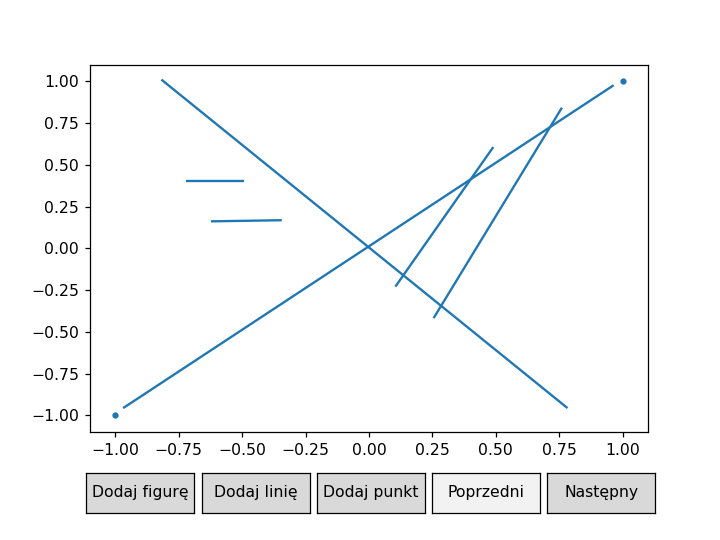

In [24]:
plot31 = Plot(points = [PointsCollection([(-1,-1),(1,1)], marker = ".")])
plot31.draw()

5


<IPython.core.display.Javascript object>


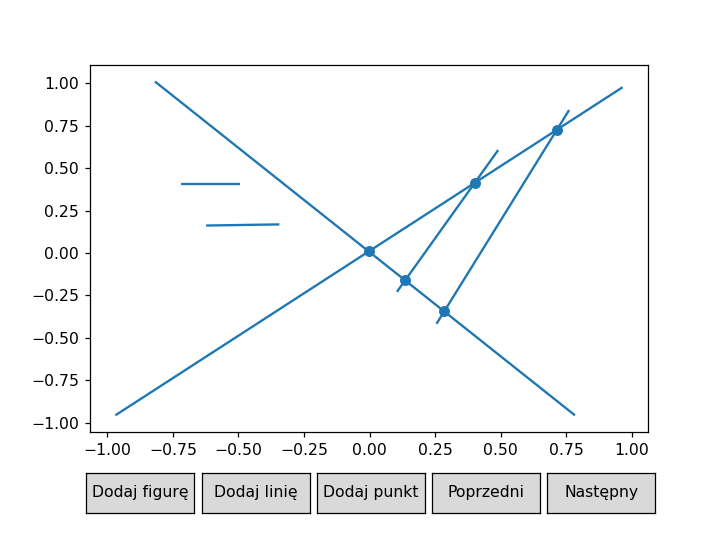

In [25]:
lines3 = plot31.get_added_lines()[0].lines
res3,sc3 = intersections(lines3)
if len(res3) != 0:
    plot32 = Plot( lines = [LinesCollection(lines3)], points = [PointsCollection(res3)] )
    plot32.draw()
else:
    print("there's no intersection")

<IPython.core.display.Javascript object>


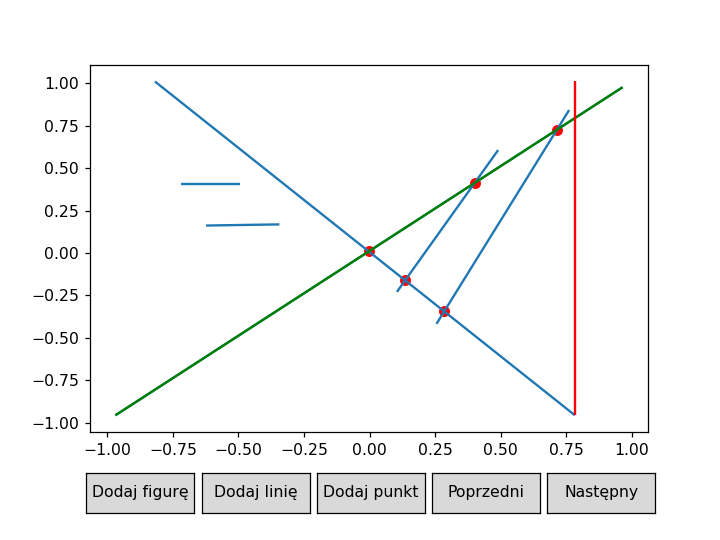

In [48]:
plot33 = Plot(scenes = sc3)

plot33.draw()
save = False
if save == True:
    with open('saved_file1.json', 'w+') as f:
        f.write(Plot(scenes = sc3).toJson())

10


<IPython.core.display.Javascript object>


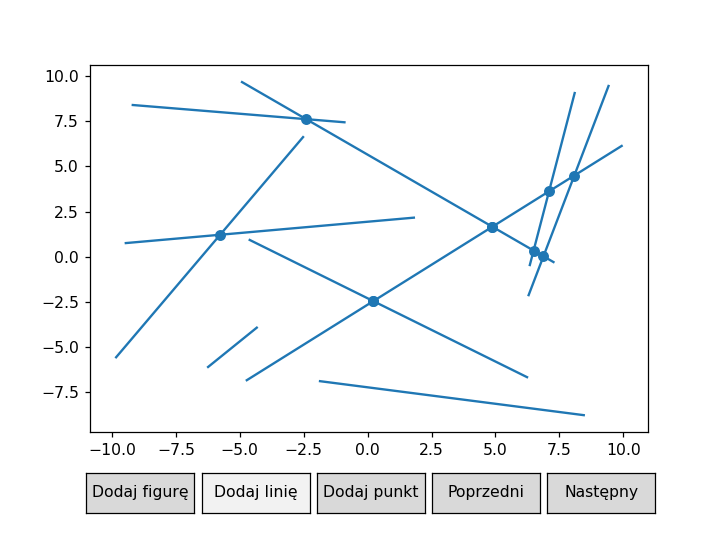

In [46]:
lines4 = generate()
res4,sc4 = intersections(lines4)
if len(res4) != 0:
    plot41 = Plot( lines = [LinesCollection(lines4)], points = [PointsCollection(res4)] )
    plot41.draw()
else:
    print("there's no intersection")

<IPython.core.display.Javascript object>


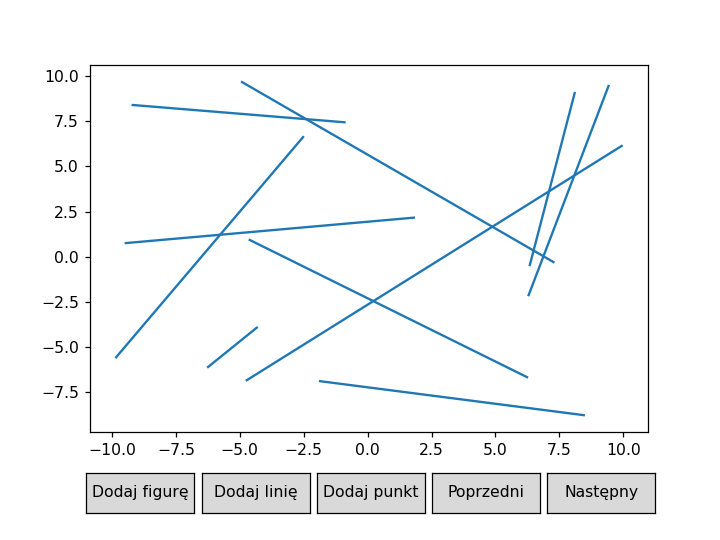

In [49]:
plot42 = Plot(scenes = sc4)

plot42.draw()

save = False
if save == True:
    with open('saved_file2.json', 'w+') as f:
        f.write(Plot(scenes = sc4).toJson())

In [50]:
from PIL import Image, ImageDraw
def create_a_gif(name, save_to, scenes):
    plt.ioff()
    plot = Plot(scenes = scenes)
    for i in range(len(plot.scenes)):
        plot.save(i, path = save_to)
    images=[Image.open(save_to+'/figure_'+str(i)+'.png') for i in range(len(plot.scenes))]
    image = Image.new('RGB', (640, 480), (255, 255, 255))
    image.save(name, save_all=True, append_images=images,duration=200, loop=0)
    plt.ion()

create_a_gif('one_intersection_1.gif', 'figs',scenes1)
create_a_gif('one_intersection_2.gif', 'figs',scenes2)
create_a_gif('intersections_1.gif', 'figs',sc3)
create_a_gif('intersections_2.gif', 'figs',sc4)